# A benchmark Pairs Trading strategy 

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
# just set the seed for the random number generator
np.random.seed(107)

In [2]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [5]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [6]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [7]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')

In [8]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2015',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 116 tickers
Total of 116 tickers after removing tickers with Nan values


In [9]:
len(df_prices_train)+len(df_prices_test)

78102

# Load Pairs

In [10]:
with open('data/etfs/pickle/2015-2019/pairs_unsupervised_learning_optical_intraday_p005_seed0.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

In [11]:
len(pairs)

19

# Apply trading strategies

**Applying the fixed beta strategy in validation period**

In [13]:
train_val_split = '2017-01-01'

# intraday
n_years_val = round(len(df_prices_train[train_val_split:])/(240*78))

# interday
#n_years_val = round(len(df_prices_train)/(240))

n_years_val

1

In [14]:
train_results_without_costs, train_results_with_costs, performance_threshold_train = \
        trader.apply_trading_strategy(pairs, 
                                        strategy='fixed_beta',
                                        entry_multiplier=2,
                                        exit_multiplier=0,
                                        test_mode=False,
                                        train_val_split=train_val_split
                                       )

sharpe_results_threshold_train_nocosts, cum_returns_threshold_train_nocosts = train_results_without_costs
sharpe_results_threshold_train_w_costs, cum_returns_threshold_train_w_costs = train_results_with_costs

 entry delay turned on.
Pair: 19/19

Average SR:  1.5483788993007626
Annual ROI:  14.059902070119556
94.73684210526316 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  4.461289377478255
Autocorrelation:  0.06097436054547318
Daily Sharpe Ratio 0.26275295929266274
Total number of trades:  45
Positive trades:  43
Negative trades:  2
Total Drawdown Days: 100 days
Max DD period: 10.0 days
Maximum drawdown of portfolio: -1.36%
14.06% - 4.17  -1.36%-10.0d - 100d


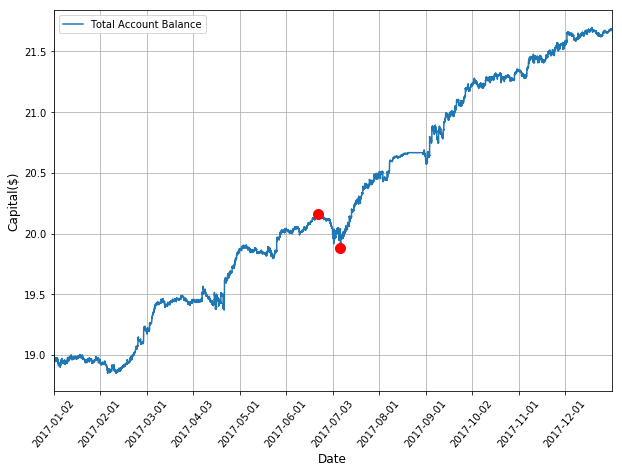

In [15]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_train_w_costs,
                                                  cum_returns_threshold_train_w_costs,
                                                  performance_threshold_train,
                                                  pairs, ticker_segment_dict,
                                                  n_years_val)

In [16]:
print('Corrected Annualized SR: {:.2f}'.format(0.26275295929266274*14.31))

Corrected Annualized SR: 3.76


# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [17]:
# intraday
n_years_test = round(len(df_prices_test)/(240*78))

# interday
#n_years_test = round(len(df_prices_test)/(240))

n_years_test

1

### Approach 1: Keeping every pair

**Basic Threshold Strategy**

In [18]:
results_without_costs, results_with_costs, performance_threshold_test = trader.apply_trading_strategy(pairs,
                                                                                             'fixed_beta',
                                                                                             2,
                                                                                             0,
                                                                                             test_mode=True)
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 19/19

Average SR:  0.9368654358336238
Annual ROI:  11.064067520511589
73.6842105263158 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  3.2946722183531043
Autocorrelation:  -0.10767179898088262
Daily Sharpe Ratio 0.19691023638433994
Total number of trades:  33
Positive trades:  28
Negative trades:  5
Total Drawdown Days: 90 days
Max DD period: 3.0 days
Maximum drawdown of portfolio: -1.06%
11.06% - 3.13  -1.06%-3.0d - 90d


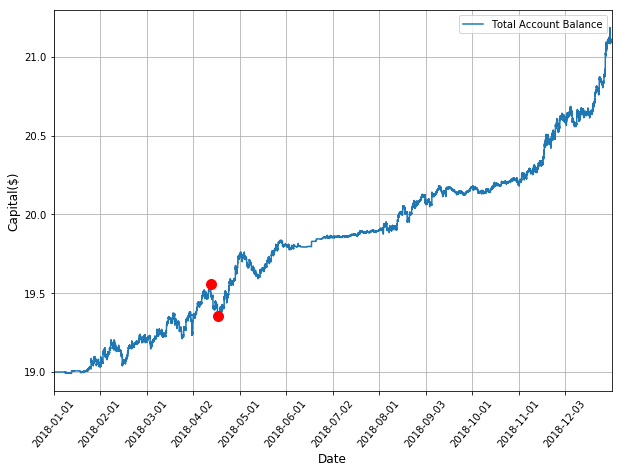

In [19]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  pairs, ticker_segment_dict,
                                                  n_years_test)

In [20]:
print('Corrected Annualized SR: {:.2f}'.format(0.19691023638433994*17.47))

Corrected Annualized SR: 3.44


### Approach 2: Keeping only pairs that had positive returns in the training period

In [21]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
profitable_pairs_indices = np.argwhere(cum_returns_threshold_train_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [22]:
results_without_costs, results_with_costs, performance_threshold_test = trader.apply_trading_strategy(
                                                                                    profitable_pairs, 
                                                                                    'fixed_beta',
                                                                                    2,#entry_multiplier,
                                                                                    0,#exit_multiplier,
                                                                                    test_mode=True)
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 18/18

Average SR:  0.9621684744836758
Annual ROI:  11.326546095213175
72.22222222222223 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  3.2681150018531056
Autocorrelation:  -0.10001602168975006
Daily Sharpe Ratio 0.19513198575206497
Total number of trades:  30
Positive trades:  26
Negative trades:  4
Total Drawdown Days: 89 days
Max DD period: 3.0 days
Maximum drawdown of portfolio: -1.12%
11.33% - 3.10  -1.12%-3.0d - 89d


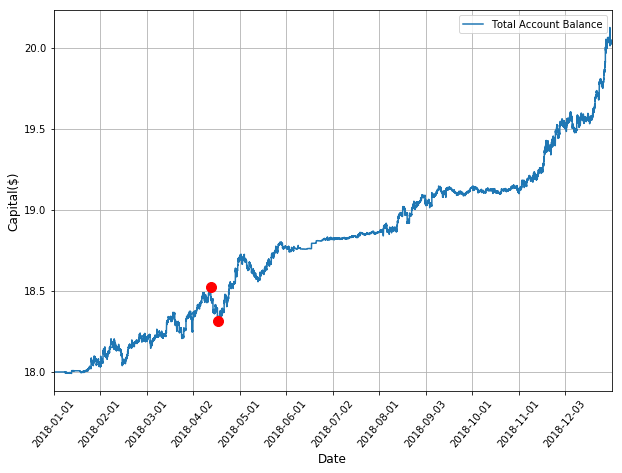

In [23]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years_test)

In [26]:
print('Corrected Annualized SR: {:.2f}'.format(0.19513198575206497*17.47))

Corrected Annualized SR: 3.41


In [25]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,DBO,Commodities: Energy Crude Oil,UGA,Commodities: Energy Gasoline,-4.194600,0.000673,427,1135,0.454642,2,0,2.006874,100.000000
1,NIB,Commodities: Agriculture Cocoa,WEAT,Commodities: Agriculture Wheat,-3.506118,0.007831,269,2429,0.486933,2,0,1.942426,100.000000
2,MLPA,Equity: U.S. MLPs,MLPX,Equity: U.S. MLPs,-2.931210,0.041837,533,361,0.303033,2,0,1.889711,100.000000
3,CORN,Commodities: Agriculture Corn,WEAT,Commodities: Agriculture Wheat,-4.655401,0.000102,602,455,0.431568,2,0,1.830332,100.000000
4,DZZ,Inverse Commodities: Precious Metals Gold,GLL,Inverse Commodities: Precious Metals Gold,-3.169423,0.021824,1795,84,0.298771,5,1,1.748273,83.333333
5,UGA,Commodities: Energy Gasoline,USL,Commodities: Energy Crude Oil,-3.764225,0.003295,493,984,0.429628,1,0,1.654512,100.000000
6,DZZ,Inverse Commodities: Precious Metals Gold,DGLD,Inverse Commodities: Precious Metals Gold,-3.601674,0.005729,1843,82,0.316851,2,0,1.606586,100.000000
7,UGA,Commodities: Energy Gasoline,BNO,Commodities: Energy Crude Oil,-3.604746,0.005671,498,1068,0.443737,1,0,1.571191,100.000000
8,UGA,Commodities: Energy Gasoline,USO,Commodities: Energy Crude Oil,-3.704281,0.004053,489,1326,0.466427,1,0,1.328667,100.000000
9,NLR,Equity: Global Nuclear Energy,RJZ,Commodities: Broad Market Metals,-4.056962,0.001140,185,612,0.412958,1,0,0.894352,100.000000
